### Sentiment Classification Using BERT

By: Fawad Kirmani

Last modified on: 11/08/2020

In [22]:
import glob
import os
import pandas as pd
import numpy as np
from numpy import array
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Importing data

In [23]:
pos_train_file = "./aclImdb_v1/aclImdb/train/pos/"
neg_train_file = "./aclImdb_v1/aclImdb/train/neg/"
pos_test_file = "./aclImdb_v1/aclImdb/test/pos/"
neg_test_file = "./aclImdb_v1/aclImdb/test/neg/"

In [24]:
input_files = [pos_train_file, neg_train_file, pos_test_file, neg_test_file]

In [25]:
def import_data(filename):
    file_list = glob.glob(os.path.join(os.getcwd(), filename, "*.txt"))

    input_data = []

    for file_path in file_list:
        with open(file_path) as f_input:
            input_data.append(f_input.read())
    return input_data

In [26]:
def overall_data(input_files):
    data = pd.DataFrame()
    for i in range(len(input_files)):
        df = pd.DataFrame(import_data(filename=input_files[i]), columns = ["reviews"])
        if input_files[i].find("/pos") > 0:
            df["label"] = 1
        else:
            df["label"] = 0
        if input_files[i].find("/train") > 0:
            df["data_type"] = "train"
        else:
            df["data_type"] = "test"
        data = data.append(df)
    data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data.dropna(axis=0,inplace=True)
    return data

In [27]:
data = overall_data(input_files=input_files)

In [28]:
data.head()

,reviews,label,data_type
0,This is one of the best films we watched in my...,1,train
1,Spoiler This movie is about such a concept. Wi...,1,train
2,Richard Attenborough is a director whose name ...,1,train
3,"Joan Crawford had just begun her ""working girl...",1,train
4,I have just read the lead comment for this fil...,1,train


Used the following tutorials to learn training language models using ktrain

https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c

#### Importing Ktrain

In [29]:
import ktrain
from ktrain import text

#### Processing Input data with BERT with max_features=100000 and maxlen=256

In [30]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(data, 
                                                                   'reviews', 
                                                                   label_columns=['label'],
                                                                   maxlen=256, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [11]:
bert_model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)
bert_learner = ktrain.get_learner(bert_model, 
                                  train_data=(x_train, y_train), 
                                  val_data=(x_test, y_test), 
                                  batch_size=32)

Is Multi-Label? False
maxlen is 256
done.


#### finding a good learning rate

In [ ]:
bert_learner.lr_find(max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1204/1407 [========================>.....] - ETA: 1:18:17 - loss: 0.4398 - accuracy: 0.7660

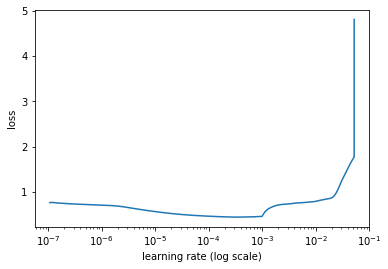

In [15]:
bert_learner.lr_plot()

In [ ]:
bert_learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
  29/1407 [..............................] - ETA: 9:00:15 - loss: 0.7132 - accuracy: 0.4838

#### Classification Report

In [16]:
bert_learner.validate(val_data=(x_test, y_test), class_names=[0,1])

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2499
           1       0.93      0.93      0.93      2501

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



array([[2331,  168],
       [ 172, 2329]])

#### Building Confusion Matrix

In [6]:
cm = array([[2331,  168], [ 172, 2329]])

In [7]:
cm

array([[2331,  168],
       [ 172, 2329]])

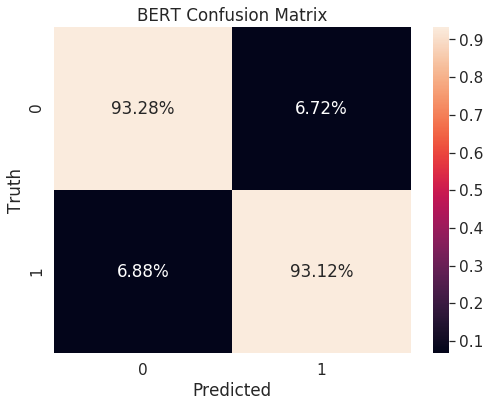

In [13]:
cm_df = pd.DataFrame(cm, range(2), range(2)) 
plt.figure(figsize = (8, 6)) 
plt.title('BERT Confusion Matrix')
sn.set(font_scale=1.4) #for label size 
sn.heatmap(cm_df/np.sum(cm_df, axis=1), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.savefig('./figures/' + 'Bert' + '_confusion_matrix_normalized.png', dpi=300)
plt.show()